# Определение рыночной цены автомобиля

## Введение

**Описание проекта:** Заказчик - Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

**Цель проекта:** Разработать модель машинного обучения, которая позволит на основании характеристик автомобиля прогнозировать рыночную стоимость автомобиля.

**Описание данных:**

В нашем распоряжении файл `'autos.csv'`, в нем:

Характеристики (Входные признаки)

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Цена (Целевой признак)
- `Price` — цена (евро)

**План работ:**
- Загрузить и изучить данные
- Провести предобработку данных
- Провести исследовательский анализ данных
    - Изучить распределения количественных, категориальных признаков
    - Провести корреляционный анализ данных
- Разработать модели машинного обучения, сравнить их скорость обучения и значение метрики RMSE на тестовой выборке
- Оформить итоговый вывод

## Загрузка данных и первоначальное изучение

In [1]:
# Установка библиотек
#!pip install phik -q
#!pip install lightgbm -q
#!pip install scikit-learn==1.4 -q
#!pip install matplotlib -q
#!pip install seaborn==0.11.1 -q

In [2]:
# Опционально: отключаем предупреждения
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Необходимые импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import phik

from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder)
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error


Bad key text.latex.preview in file /opt/anaconda3/envs/practicum/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.3/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/anaconda3/envs/practicum/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.3/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/anaconda3/envs/practicum/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_qualit

In [4]:
# Считываем данные
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

#### Знакомство с данными

Выведем первые 10 строк таблицы и общую информацию о таблице, изучим их

In [5]:
display(data.head(10))
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

#### Общий вывод по Первоначальному изучению данных
Данные соответствуют описанию. Обратим внимание, что в некоторых столбцах есть пропуски, их необходимо обработать (на этапе предобработки), названия столбцов необходимо привести к нижнему регистру, некоторые столбцы несут информацию, которая никак не может влиять на цену автомобиля (они будут удалены на этапе предобработки). Типы данных неоптимальны только для дат.

Можно двигаться дальше.

## Предобработка данных

### Обработка названий столбцов

Для начала приведем названия столбцов к нижнему регистру для большего удобства

In [6]:
data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Можно двигаться дальше.

### Обработка пропущенных значений

Изучим пропуски в `'vehicle_type'`

In [7]:
display(data.loc[data['vehicle_type'].isna()].head(10))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08


Пропуски выглядят случайными. Используем категорию 'other' для пропусков в этой колонке, чтобы не удалять данные.

In [8]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')

Изучим пропуски в `'gearbox'`

In [9]:
display(data.loc[data['gearbox'].isna()].head(10))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,other,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,other,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,other,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01 00:00:00,0,47249,2016-04-07 08:46:07
92,2016-03-16 07:56:19,250,other,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16 00:00:00,0,51427,2016-03-21 09:47:08
94,2016-03-28 16:37:43,8390,other,2009,NaN,0,insignia,150000,0,NaN,opel,NaN,2016-03-28 00:00:00,0,29221,2016-03-30 07:44:59
110,2016-04-03 03:57:26,350,small,1998,NaN,0,corsa,150000,2,petrol,opel,NaN,2016-04-03 00:00:00,0,82110,2016-04-03 08:53:37
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22


Пропуски выглядят случайными. Используем заглушку 'unknown', чтобы не удалять данные.

Изучим пропуски в `'model'`

In [10]:
display(data.loc[data['model'].isna()].head(10))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03 00:00:00,0,45665,2016-04-05 11:47:13
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31
151,2016-03-27 20:47:22,6799,small,2009,NaN,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27 00:00:00,0,89077,2016-03-27 20:47:22
160,2016-03-19 19:49:15,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,2016-03-19 00:00:00,0,26969,2016-04-01 11:17:48
161,2016-03-28 10:50:04,1495,wagon,2001,NaN,64,NaN,150000,9,gasoline,volkswagen,NaN,2016-03-28 00:00:00,0,99086,2016-04-04 11:45:46
186,2016-03-16 15:51:08,14000,sedan,2008,NaN,235,NaN,150000,0,NaN,bmw,no,2016-02-12 00:00:00,0,95131,2016-04-07 14:56:12
193,2016-03-27 12:47:45,1200,coupe,1990,manual,45,NaN,150000,0,petrol,volkswagen,NaN,2016-03-27 00:00:00,0,83317,2016-04-07 08:17:08


Пропуски выглядят случайными. Используем заглушку 'unknown', чтобы не удалять данные.

Изучим пропуски в `'fuel_type'`

In [11]:
display(data.loc[data['fuel_type'].isna()].head(10))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
13,2016-03-21 21:37:40,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,2016-03-21 00:00:00,0,90762,2016-03-23 02:50:54
26,2016-03-10 19:38:18,5555,other,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09
41,2016-03-30 20:38:20,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,2016-03-30 00:00:00,0,33649,2016-04-03 11:44:49
52,2016-04-04 10:57:36,1400,other,2016,manual,55,other,5000,1,NaN,hyundai,NaN,2016-04-04 00:00:00,0,34454,2016-04-06 12:45:43
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32
57,2016-03-10 20:53:19,2399,other,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
65,2016-03-28 17:41:27,10900,other,2017,manual,101,astra,50000,3,NaN,opel,no,2016-03-28 00:00:00,0,63607,2016-04-06 23:15:52


Пропуски выглядят случайными. Используем заглушку 'unknown', чтобы не удалять данные.

Изучим пропуски в `'repaired'`

In [12]:
display(data.loc[data['repaired'].isna()].head(10))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
12,2016-03-15 22:49:09,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,2016-03-15 00:00:00,0,37269,2016-04-01 13:16:16
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,other,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
31,2016-03-29 16:57:02,899,other,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09
40,2016-03-26 22:06:17,0,other,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34


Пропуски выглядят случайными. Используем заглушку 'unknown', чтобы не удалять данные.

In [13]:
for column in ['gearbox', 'model', 'fuel_type', 'repaired']:
    data[column] = data[column].fillna('unknown')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  repaired            354369 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Пропуски удалены, можно двигаться дальше.

### Обработка дубликатов

Проверим, есть ли в данных явные дубликаты

In [14]:
data.duplicated().sum()

4

Найдено 4, удалим их.

In [15]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Проверим, есть ли в даннных неявные дубликаты по типу автомобиля, модели, коробке передач, типу топлива, марке, починке:

In [16]:
for column in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']:
    print(column + ':', sorted(data[column].unique()), '\n')

vehicle_type: ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon'] 

gearbox: ['auto', 'manual', 'unknown'] 

model: ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'e

Среди значений типов топлива gasoline и petrol означают одно и то же. Заменим все на gasoline.

In [17]:
data.loc[data['fuel_type'] == 'petrol', 'fuel_type'] = 'gasoline'

Неявные дубликаты отсутствуют. Можно двигаться дальше.

### Удаление не информативных столбцов

Удалим столбцы, которые не несут информации, которая позволит модели лучше определять рыночную цену. Это столбцы `'date_crawled'`, `'registration_month'`, `'postal_code'`, `'last_seen'`, `'number_of_pictures'`, `'date_created'`

In [18]:
data = data.drop(['date_crawled', 'registration_month',
                 'postal_code', 'last_seen', 'number_of_pictures', 'date_created'], axis=1)
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,gasoline,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


#### Общий вывод по Предобработке данных:
- Пропуски в данных отсутствуют
- Явные дубликаты отсутствуют
- В таблице содержится только нужная информация

## Исследовательский анализ данных

### Распределения количественных признаков

Построим графики для всех количественных признаков, чтобы изучить распределения

In [19]:
# description отвечает за вывод описания данных
def show_hist(feature, description=False):
    data[feature].hist(bins=30, grid=True, legend=False)
    plt.ylabel('Частота')
    plt.xlabel(feature)
    plt.title(f'Распределение признака {feature}')
    plt.show()
    if description == True:
        print(data[feature].describe())

#### Целевой признак - цена

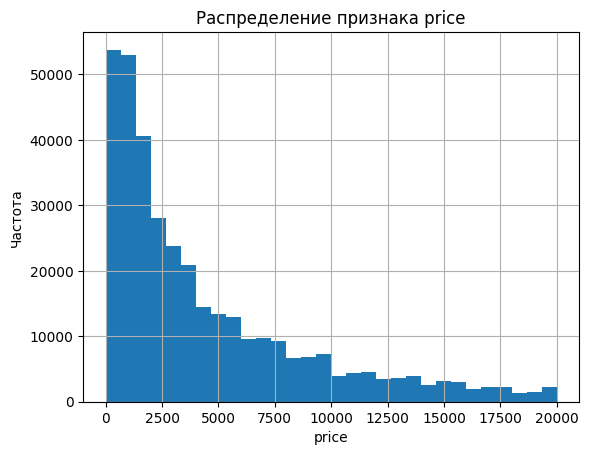

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64


In [20]:
show_hist('price', description=True)

#### Интерпретация графика
- Распределение не имеет форму нормального - при увеличении цены, частота встречаемых автомобилей уменьшается
- Средняя цена 4416 евро, медианное значение 2700
- Присутствует странный пик около 0 - необходимо проверить эти данные

In [21]:
display(data.loc[data['price'] < 100].head(10))
print('Количество строк с ценой меньше 100 евро:',
      (data.loc[data['price'] < 100, 'price'].count()))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
7,0,sedan,1980,manual,50,other,40000,gasoline,volkswagen,no
40,0,other,1990,unknown,0,corsa,150000,gasoline,opel,unknown
59,1,suv,1994,manual,286,unknown,150000,unknown,sonstige_autos,unknown
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
111,0,other,2017,manual,0,golf,5000,gasoline,volkswagen,unknown
115,0,small,1999,unknown,0,unknown,5000,gasoline,volkswagen,unknown
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
154,0,other,2006,unknown,0,other,5000,unknown,fiat,unknown
231,0,wagon,2001,manual,115,mondeo,150000,unknown,ford,unknown
268,1,sedan,1990,manual,90,80,70000,gasoline,audi,no


Количество строк с ценой меньше 100 евро: 13314


Машин с подозрительно низкой ценой достаточно много, необходимо заменить эти значения. Чтобы сильно не исказить общую картину, заменим цены на медианную цену по модели, так как медиана более робастна, чем среднее значение. Это также позволит нам избежать влияния выбросов в категории `'other'`.

In [22]:
for model in data['model'].unique():
    data.loc[(data['price'] < 100) & (data['model'] == model),
             'price'] = round(data.loc[data['model'] == model, 'price'].median())

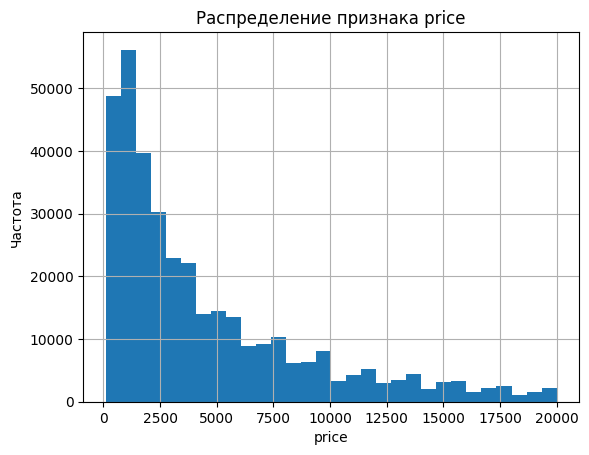

In [23]:
# Повторно выведем график
show_hist('price')

Выбросы устранены, можно двигаться дальше.

#### Входные признаки: мощность двигателя, пробег

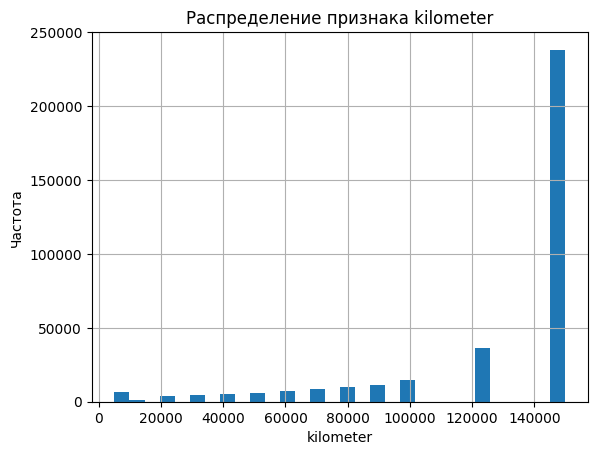

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


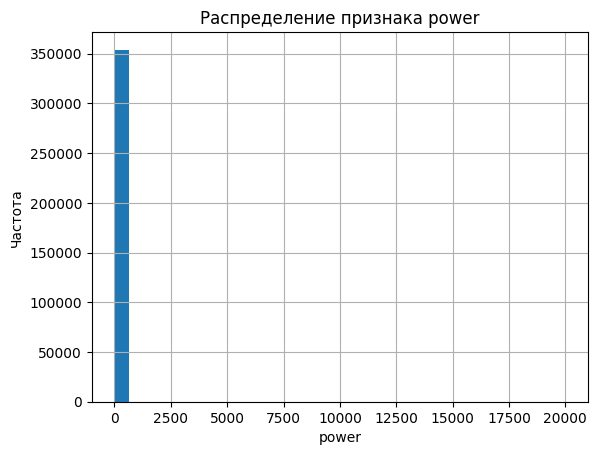

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


In [24]:
for feature in ['kilometer', 'power']:
    show_hist(feature, description=True)

#### Интерпретация графиков
- Распределение значения пробега не имеет форму нормального, большая часть (более 240000 автомобилей) имеют пробег более 140 000 км. Выбросы и аномалии не обнаружены.
- На графике распределения мощности двигателя есть явные аномалии (экстремально большие значения, нулевые значения), изучим их более детально

In [25]:
# Выведем данные об автомобилях с подозрительно большой мощностью
data.loc[data['power'] >= 350].sort_values(by='power', ascending=False)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
219584,4300,coupe,1999,auto,20000,clk,150000,gasoline,mercedes_benz,no
299180,1500,wagon,1997,manual,19312,5er,150000,unknown,bmw,no
114106,9999,sedan,2006,manual,19211,1er,125000,gasoline,bmw,unknown
132485,2100,wagon,2001,manual,19208,5er,150000,unknown,bmw,yes
63986,3250,sedan,2001,auto,17932,omega,150000,gasoline,opel,unknown
...,...,...,...,...,...,...,...,...,...,...
65886,14900,wagon,2007,auto,350,3er,150000,gasoline,bmw,unknown
151237,2999,wagon,1999,auto,350,a6,150000,gasoline,audi,no
152374,9999,sedan,2006,auto,350,a8,150000,gasoline,audi,yes
153643,11500,wagon,2006,auto,350,5er,150000,gasoline,bmw,no


Мощность двигателя не может достигать 20 000 л.с., поэтому в данных точно ошибка, также, как и 0. Заменим значения медианным по модели.

In [26]:
# Замена экстремально больших значений и нулей медианой по модели
for model in data['model'].unique():
    data.loc[(data['model'] == model) & ((data['power'] >= 350) | (data['power'] < 30)),
             'power'] = round(data.loc[data['model'] == model, 'power'].median())

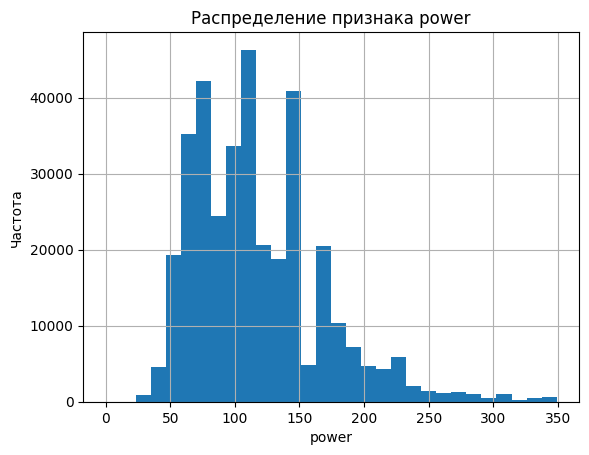

count    354365.000000
mean        117.365126
std          50.642795
min           0.000000
25%          75.000000
50%         109.000000
75%         143.000000
max         349.000000
Name: power, dtype: float64


In [27]:
show_hist('power', description=True)

#### Интерпретация графика
- Форма распределения напоминает нормальное, смещенное влево, но присутствуют пики около 75, 120 и 150 л.с. Эти пики не вызывают вопросов, так как эти значения походят на типовые значения мощности двигателей
- Среднее значение 117.36 л.с., медиана 109 л.с.

#### Распределение года регистрации автомобиля

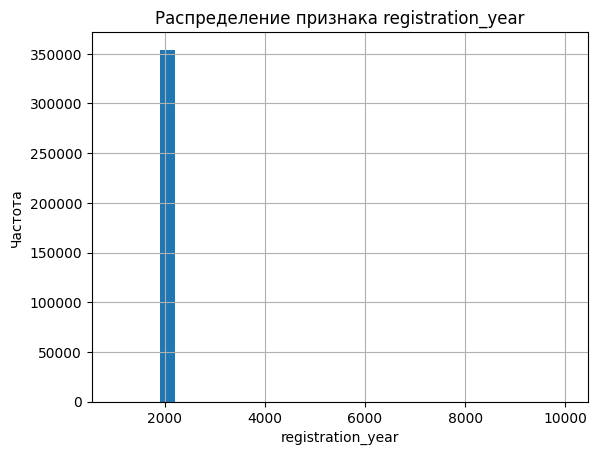

In [28]:
show_hist('registration_year')

В данных присутствуют явные выбросы (автомобили, зарегистрированные после 2024). Проверим, какой процент данных мы потеряем, если удалим их

In [29]:
data.loc[(data['registration_year'] > 2017), 'registration_year'].count() / data['price'].count()

0.011538949952732353

Чуть более 1%. Удалим эти строки, чтобы они не мешали адекватному обучению модели.

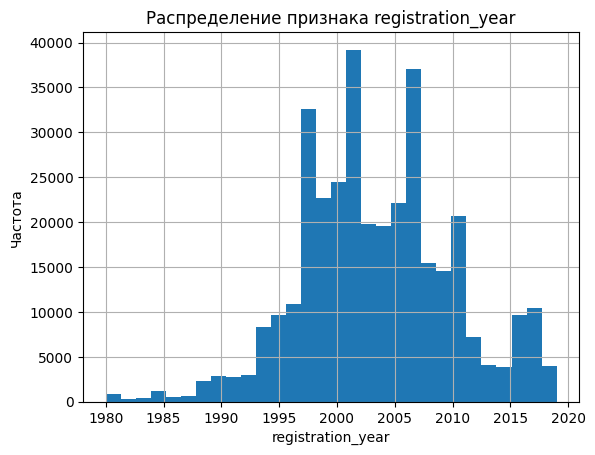

count    350808.000000
mean       2003.423046
std           6.611349
min        1980.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64


In [30]:
data = data.loc[((data['registration_year'] < 2024) & (data['registration_year'] >= 1980))]
show_hist('registration_year', description=True)

Выбросы устранены, можно двигаться дальше.

#### Интерпретация графика
- Среднее значение 2004 год, медиана 2003.
- Форма распределения напоминает нормальное, смещенное вправо, с пиками в районе 1997, 2002 и 2006

### Категориальные признаки

#### Тип автомобиля и марка

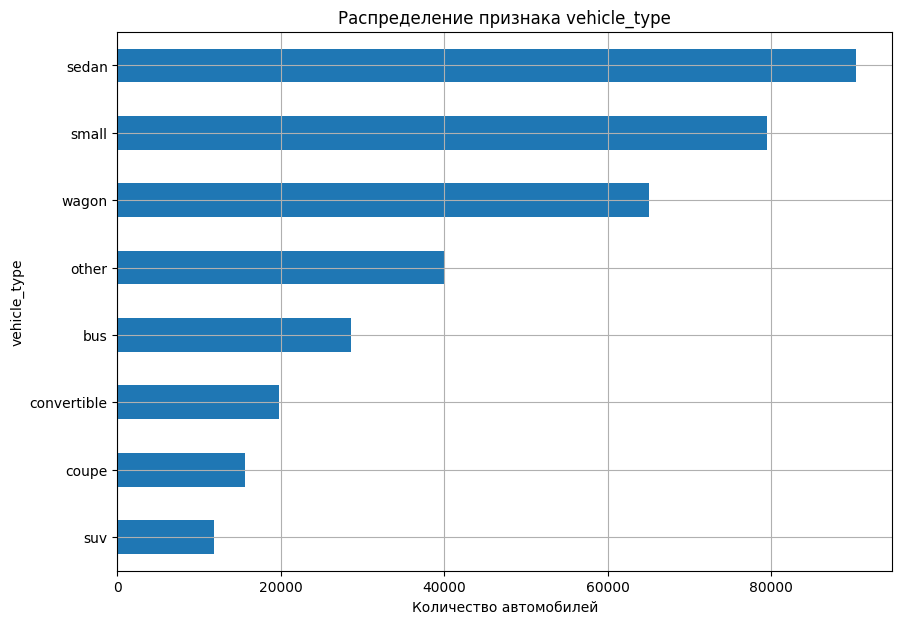

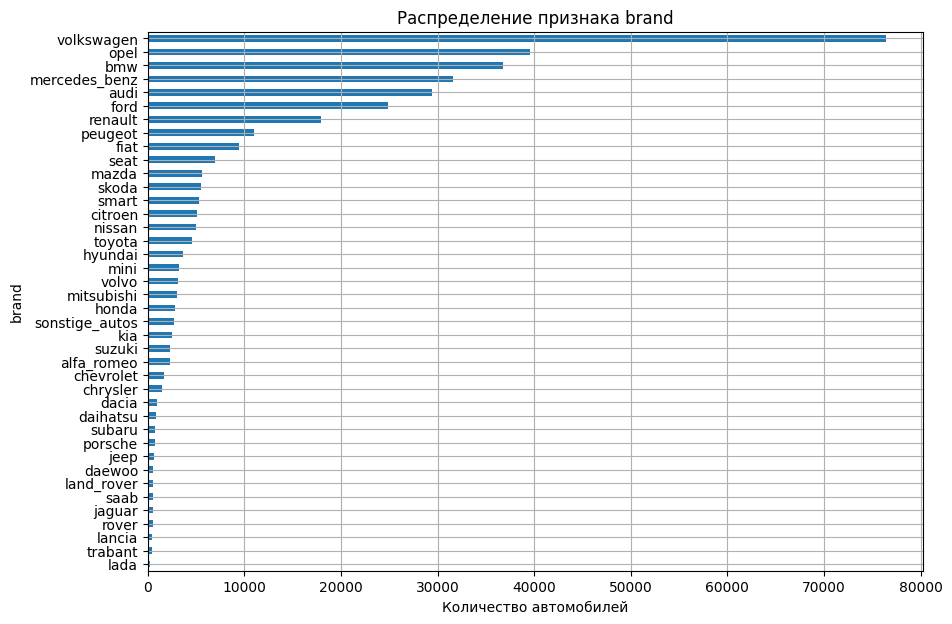

In [31]:
for feature in ['vehicle_type', 'brand',]:
    (data
    .pivot_table(index=feature, values='price', aggfunc='count')
    .sort_values(by='price')
    .plot(kind='barh', legend=False, grid=True, figsize=(10,7)))
    plt.xlabel('Количество автомобилей')
    plt.ylabel(feature)
    plt.title(f'Распределение признака {feature}')
    plt.show()

#### Интерпретация графиков:
- Наиболее популярные автомобили для продажи - седан (около 90 000), далее идут мини-автомобили (80 000), универсалы (75 000). Наименее популярные - Внедорожники (15 000) и Купе (17 000)
- Наиболее популярные марки автомобилей - Volkswagen (75 000), далее с большим отрывом Opel, BMW, Mercesed, Audi (менее 40 000). Наименее популярные - Lada, Lancia, Rover, Jaguar, их показатели сильно далеки от остальных марок (менее 2 тыс.)

#### Тип коробки передач и починка автомобиля

Эти признаки будут визуализированы с помощью круговой диаграммы

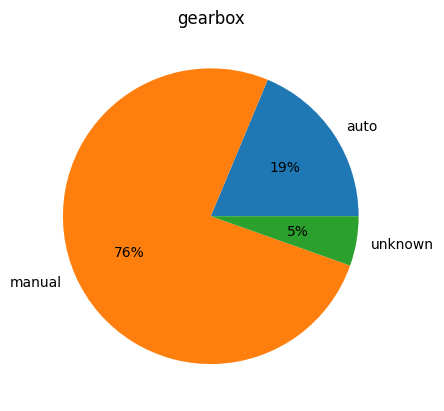

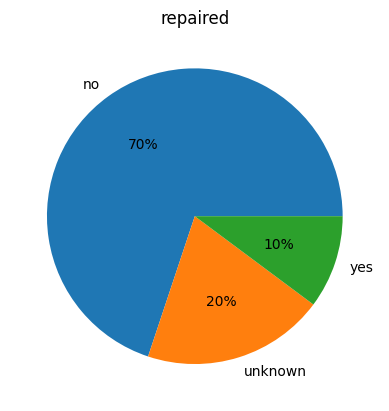

In [32]:
for feature in ['gearbox', 'repaired']:
    (data
    .pivot_table(index=feature, values='price', aggfunc='count')
    .plot(kind='pie', y='price', legend=False, autopct='%1.0f%%'))
    plt.title(feature)
    plt.ylabel('')
    plt.show()

####  Интерпретация графиков
- 76% автомобилей на механической коробке, 19% оснащены автоматической
- 70% автомобилей не ремонтировались, 10% ремонтировались, при том у 20% автомобилей значение признака неизвестно

### Корреляционный анализ данных

Построим тепловую карту на основе матрицы корреляции между входными признаками и целевым, чтобы избавиться от мультиколлинеарности. Будем использовать phik, так как не все распределения имеют форму нормального.

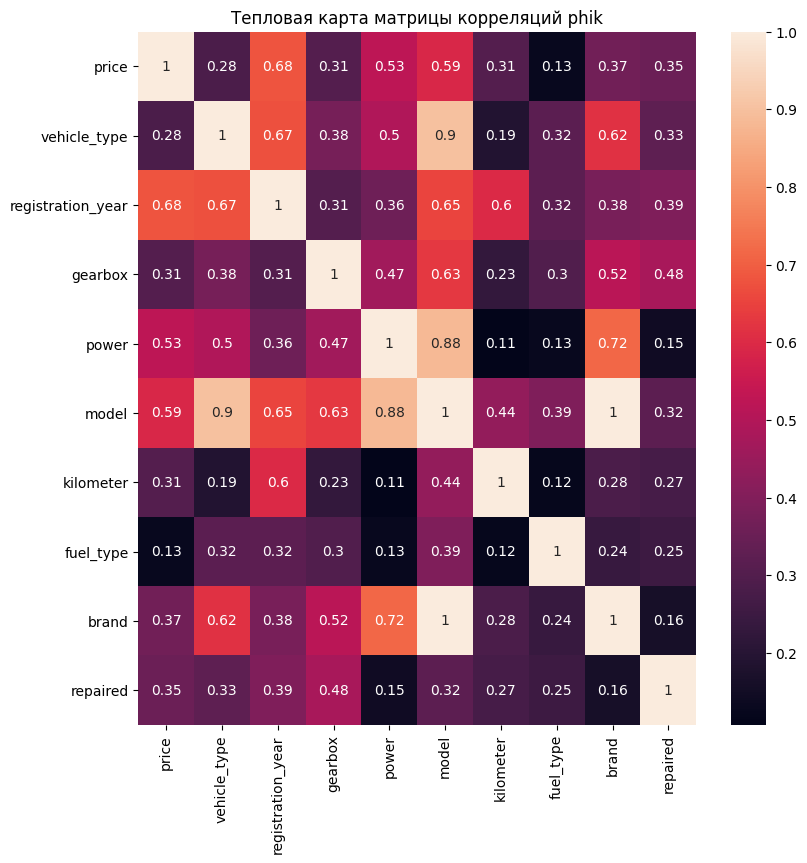

In [33]:
matrix = data.phik_matrix(interval_cols=['price', 'power', 'kilometer'])
plt.figure(figsize=(9,9))
sns.heatmap(data=matrix, annot=True)
plt.title('Тепловая карта матрицы корреляций phik')
plt.show()

#### Интерпретация графика
- Присутствует мультиколлинеарность между моделью и маркой автомобиля, модель лучше влияет на цену, так что марку можно удалить
- Присутствует значительная зависимость цены от года регистрации автомобиля и модели, остальные признаки умеренно влияют на цену.

In [34]:
data = data.drop('brand', axis=1)

### Общий вывод по Исследовательскому анализу данных

- Распределение **цены** не имеет форму нормального - при увеличении цены, частота встречаемых автомобилей уменьшается. Средняя цена 4416 евро, медианное значение 2700. Выбросы и аномалии устранены.
- Распределение значения пробега не имеет форму нормального, большая часть (более 240000 автомобилей) имеют пробег более 140 000 км. Выбросы и аномалии не обнаружены.
- Форма распределения мощности двигателя напоминает нормальное, смещенное влево, но присутствуют пики около 75, 120 и 150 л.с. Эти пики не вызывают вопросов, так как эти значения походят на типовые значения мощности двигателей. Среднее значение 117.36 л.с., медиана 109 л.с. Выбросы и аномалии устранены.
- Форма распределения года регистрации ТС напоминает нормальное, смещенное вправо, с пиками в районе 1997, 2002 и 2006. Среднее значение 2004 год, медиана 2003.
- Наиболее популярные автомобили для продажи - седан (около 90 000), далее идут мини-автомобили (80 000), универсалы (75 000). Наименее популярные - Внедорожники (15 000) и Купе (17 000)
- Наиболее популярные марки автомобилей - Volkswagen (75 000), далее с большим отрывом Opel, BMW, Mercesed, Audi (менее 40 000). Наименее популярные - Lada, Lancia, Rover, Jaguar, их показатели сильно далеки от остальных марок (менее 2 тыс.)
- 76% автомобилей на механической коробке, 19% оснащены автоматической.
- 70% автомобилей не ремонтировались, 10% ремонтировались, при том у 20% автомобилей значение признака неизвестно.
- Присутствует мультиколлинеарность между моделью и маркой автомобиля, модель лучше влияет на цену, признак Марка машины удален.
- Присутствует значительная зависимость цены от года регистрации автомобиля и модели, остальные признаки умеренно влияют на цену.

## Обучение моделей МО

Для сравнения будут использованы модели Регрессия на базе дерева решений и бустинг LightGBM.

Необходимо при помощи пайплайнов и поиска гиперпараметров найти лучшие гиперпараметры для каждой модели, оценить скорость обучения, предсказания для каждой лучшей модели.

In [35]:
# Списки переменных для кодирования
num_list = ['power', 'kilometer']
ord_list = ['gearbox', 'repaired']
ord_2_list = ['vehicle_type', 'model', 'fuel_type']

In [36]:
np.random.seed(42)
# Функция для разделения на выборки
def chose_samples(data):
    # Отделение тренировочной выборки
    X_train, X_test, y_train, y_test = train_test_split(
    data.drop('price', axis=1),
    data['price'],
    test_size=0.2
    )

    return X_train, X_test, y_train, y_test

In [37]:
X_train, X_test, y_train, y_test = chose_samples(data)

In [38]:
# Словари для подбора гиперпараметров
# реализованы не списком словарей, а отдельными переменными, так как
# необходимо оценивать скорость работы каждой модели.
tree_regressor_params = {
    'models': [DecisionTreeRegressor()],
    'models__min_samples_split': range(2, 10),
    'models__min_samples_leaf': range(1, 10),
    'models__max_depth': range(2, 7)
}

lgbm_params = {
    'models': [LGBMRegressor()],
    'models__boosting_type': ['gbdt', 'dart', 'rf']
}

In [39]:
np.random.seed(42)
# Для обучения моделей будем использовать функцию
def learn_model(params):

    # Пайплайн для обработки признаков и обучения модели
    ord_pipe = Pipeline(
        [
            ('ord', OrdinalEncoder(
                categories=[['unknown', 'manual', 'auto'],
                            ['unknown', 'no', 'yes']],
                handle_unknown='use_encoded_value', unknown_value=-1)
            )
        ]
    )
    
    ord_2_pipe = Pipeline(
        [
            ('ord', OrdinalEncoder(
                categories='auto',
                handle_unknown='use_encoded_value', unknown_value=-1)
            )
        ]
    )

    data_preprocessor = ColumnTransformer(
        [
            ('ord', ord_pipe, ord_list),
            ('ord_2', ord_2_pipe, ord_2_list),
            ('num', StandardScaler(), num_list)
        ],
        remainder='passthrough'
    )

    final_pipe = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', DecisionTreeRegressor())
        ]
    )

    # Обучение модели МО
    search = RandomizedSearchCV(
        final_pipe,
        params,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    search.fit(X_train, y_train)

    print(f'Лучшая модель: {search.best_estimator_}')

    # Вывод метрик
    print(
        f'Метрика RMSE на кросс-валидации: {-search.best_score_}')

    return search.best_estimator_

In [40]:
best_tree = learn_model(tree_regressor_params)

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['unknown',
                                                                                               'manual',
                                                                                               'auto'],
                                                                                              ['unknown',
                                                                                               'no',
                                                                                               'yes']],
                                                                                  handle_unknown='use_encoded_value',
                 

Лучшие гиперпараметры для модели получены, а теперь обучим ее не используя поиск, чтобы вычислить время обучения и предсказания отдельно.

In [41]:
# Преобразуем тренировочную и выборки
X_train_transformed = best_tree['preprocessor'].transform(X_train)

best_tree_time_test = DecisionTreeRegressor(
    max_depth=7, min_samples_leaf=6, min_samples_split=4)

In [42]:
%%time
# Обучение модели
best_tree_time_test.fit(X_train_transformed, y_train)

CPU times: user 242 ms, sys: 3.03 ms, total: 245 ms
Wall time: 244 ms


DecisionTreeRegressor(max_depth=7, min_samples_leaf=6, min_samples_split=4)

In [43]:
%%time
# Предсказание модели
tree_prediction = best_tree_time_test.predict(X_train_transformed)

CPU times: user 12 ms, sys: 1.76 ms, total: 13.8 ms
Wall time: 12.7 ms


#### Показатели Дерева решений
- RMSE на кросс-валидации 2302
- Время обучения 221 милисекунда
- Время предсказания 12.1 милисекунд

In [44]:
best_boosting = learn_model(lgbm_params)

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_0e15gqmeju/croot/lightgbm_1723565410808/work/src/boosting/rf.hpp, line 37 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_0e15gqmeju/croot/lightgbm_1723565410808/work/src/boosting/rf.hpp, line 37 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_0e15gqmeju/croot/lightgbm_1723565410808/work/src

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 280646, number of used features: 8
[LightGBM] [Info] Start training from score 4483.850434
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['unknown',
                                                                                               'manual',
                                                                                               'auto'],
                                      

Лучшие гиперпараметры для модели получены, а теперь обучим ее не используя поиск, чтобы вычислить время обучения и предсказания отдельно.

In [45]:
# Модель
best_lgbm_time_test = LGBMRegressor(max_depth=6)

In [46]:
%%time
# Обучение
best_lgbm_time_test.fit(X_train_transformed, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 280646, number of used features: 8
[LightGBM] [Info] Start training from score 4483.850434
CPU times: user 2.85 s, sys: 730 ms, total: 3.58 s
Wall time: 514 ms


LGBMRegressor(max_depth=6)

In [47]:
%%time
# Предсказание
prediction = best_lgbm_time_test.predict(X_train_transformed)

CPU times: user 1.48 s, sys: 34.7 ms, total: 1.52 s
Wall time: 206 ms


#### Показатели LightGBM
- RMSE на кросс-валидации 1813
- Время обучения 364 милисекунды
- Время предсказания 81.2 милисекунды

Модели обучены, лучший результат показывает бустинг. Выведем метрику RMSE на тестовой выборке.

#### Проверка лучшей модели на тестовой выборке

In [48]:
print(f'Значение RMSE на тестовой выборке: {root_mean_squared_error(y_test, best_boosting.predict(X_test))}')

Значение RMSE на тестовой выборке: 1809.1767191427452


### Общий вывод по Обучению моделей МО
- Обучены модели Регрессор на базе дерева решений, LightGBM. Выбраны лучшие комбинации гиперпараметров для минимизации RMSE.

#### Показатели Дерева решений
- RMSE на кросс-валидации 2302
- Время обучения 221 милисекунда
- Время предсказания 12.1 милисекунд

#### Показатели LightGBM
- RMSE на кросс-валидации 1813
- Время обучения 364 милисекунды
- Время предсказания 81.2 милисекунды

#### Рекомендации для Заказчика:
- Модель на основе LightGBM точнее на 21%, но обучается примерно на 50% дольше, пронгозирует почти 6 раз дольше. Но не смотря на это, мы рекомендуем выбрать именно эту модель.
- Если есть возможность пожертвовать 21% точности, чтобы достичь максимальной скорости, рекомендуем использовать в приложении модель на базе дерева решений, а если критично важна точность и не так важно время обучения, то рекомендуем выбрать модель на базе LightGBM.

## Общий вывод по Проекту:
- Загружены, проверены данные для обучения моделей.
- Проведена предобработка данных: обработаны пропущенные значения, обработаны дубликаты, названия столбцов, устранены не информативные для обучения моделей МО данные.
- Проведен исследовательский анализ данных: устранены аномалии и выбросы во входных признаках, изучены и проанализированы распределения признаков.
- Проведен корреляционный анализ данных: устранена мультиколлинеарность между входными признаками, установлен уровень зависимости целевого признака (цена) от входных.
- Разработаны пайплайны для обучения моделей МО. Использован алгоритм рандомного поиска для выбора лучшей комбинации гиперпараметров моделей МО.
- Обучены модели Регрессор на базе дерева решений, LightGBM. Выбраны лучшие комбинации гиперпараметров для минимизации RMSE.
    - Показатели Дерева решений
        - RMSE на кросс-валидации 2302
        - Время обучения 221 милисекунда
        - Время предсказания 12.1 милисекунд

    - Показатели LightGBM
        - RMSE на кросс-валидации 1813
        - Время обучения 364 милисекунды
        - Время предсказания 81.2 милисекунды
## Рекомендации для Заказчика
- Модель на основе LightGBM точнее на 21%, но обучается примерно на 50% дольше, пронгозирует значительно дольше. Рекомендуем использовать именно ее.
- Если есть возможность пожертвовать 21% точности, чтобы достичь максимальной скорости, рекомендуем использовать в приложении модель на базе дерева решений, а если критично важна точность и не так важно время обучения, то рекомендуем выбрать модель на базе LightGBM.